In [33]:
import numpy as np
import cv2
from PIL import Image,ImageEnhance
import copy
import matplotlib.pyplot as plt
from skimage import color
import random
import os
from alive_progress import alive_bar
from tqdm.notebook import tqdm_notebook as tqnb
import time
plt.rcParams["figure.figsize"] = (15,10)

In [34]:
# Helper functions
# definition to readfile
def readfile(path):
    file = open(path, 'r')
    return file

# defintion to fetch bounding boxes
def fetch_bboxes(path):
    file = readfile(path)
    lines = file.readlines()
    # print(lines)
    bboxes = np.empty([len(lines),5], dtype=float)
    
    for i,line in enumerate(lines):
        # print(line)
        line = line.split()[0] + ' ' + ' '.join(line.split()[4:8])
        line = line.split()
        bboxes[i,:4] = line[1:]
    return bboxes

# defintion to fetch a random number
def gen_rand_num(begin,end):
    num = random.uniform(begin,end)
    return num

# definition to write augmented values to label file
def save_newbbox(newlabel_path,orig_path,bboxes):
    file_r = readfile(orig_path)
    lines = file_r.readlines()
    labels = []
    
    for i,line in enumerate(lines):
        #line[4:8] = '200 300 400 500'
        line = line.split()
        line[4:8] = [str(bbox) for bbox in bboxes[i,:4]]
        line = ' '.join(line)
        line = line + '\n'
        labels.append(line)
    file_w = open(newlabel_path + '.txt', 'w')
    file_w.writelines(labels)
    
# defintion to save augmented image    
def save_newimg(path, img_arr):    
    #image = Image.fromarray(conv2uint8(img_arr))
    #image.save(path + '.jpg')
    cv2.imwrite(path + '.jpg', conv2uint8(cv2.cvtColor(img_arr, cv2.COLOR_RGB2BGR)))
    
# method to call save_augbbox and save_augimg
def save_newimgdata(image_info):
    save_newimg(image_info['newimg_path'] ,image_info['image_arr'])
    save_newbbox(image_info['newlabel_path'],image_info['origlabel_path'],
                 image_info['img_bboxes'])
    
def conv2uint8(image_arr):
    """image_arr = cv2.cvtColor(image_arr.
                             astype("float32"), cv2.COLOR_BGR2RGB)"""
    return (image_arr * 255).astype(np.uint8)

# Resize images to (960,544)
# Adjust bboxes as per new dims
def resize_img_bbox(img_lb_tupl,dim):
    imgf, labelf = img_lb_tupl
    width, height = dim
    # resize image
    img_arr = cv2.imread(imgf)/255
    # convert to rgb
    img_arr = cv2.cvtColor(img_arr.astype('float32'), cv2.COLOR_BGR2RGB)
    h0 = img_arr.shape[0]
    w0 = img_arr.shape[1]
    # img = img.resize((width,height))
    img_arr =  cv2.resize(img_arr,(width,height))
    # img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    # print("Updated dimensions: ", img_arr.shape)
    # Scale factor in x and y axis
    # of resized image
    scale_x = height/h0
    scale_y = width/w0
    # resize bbox
    bboxes = fetch_bboxes(labelf)
    bboxes[:,[0,2]] = bboxes[:,[0,2]] * scale_x
    bboxes[:,[1,3]] = bboxes[:,[1,3]] * scale_y
    return img_arr,bboxes

# just resize images and save
def just_resize_save(impath,newpath,dim):
    width, height = dim
    # resize image
    img_arr = cv2.imread(impath)/255
    # convert to rgb
    img_arr = cv2.cvtColor(img_arr.astype('float32'), cv2.COLOR_BGR2RGB)
    # img = img.resize((width,height))
    img_arr =  cv2.resize(img_arr,(width,height))
    # save resized image
    save_newimg(newpath,img_arr)

def imlabel(impath, labels_path):
    #impath = 'data/kitti/custom_annotated/annotated_images/'
    #labels_path = 'data/kitti/custom_annotated/labels/'
    images = sorted(os.listdir(impath))
    labels = sorted(os.listdir(labels_path))
    imlabel_list = []
    for entity in zip(images, labels):
        entity = list(entity)
        entity[0] = impath + entity[0]
        entity[1] = labels_path + entity[1]
        imlabel_list.append(tuple(entity))
    return imlabel_list

In [148]:
imlabel_list = imlabel('data/kitti/custom_annotated/annotated_images/', 'data/kitti/custom_annotated/labels/')
imlabel_list

[('data/kitti/custom_annotated/annotated_images/2-wheeler-1.jpg',
  'data/kitti/custom_annotated/labels/2-wheeler-1.txt'),
 ('data/kitti/custom_annotated/annotated_images/2-wheeler-10.jpg',
  'data/kitti/custom_annotated/labels/2-wheeler-10.txt'),
 ('data/kitti/custom_annotated/annotated_images/2-wheeler-2.jpg',
  'data/kitti/custom_annotated/labels/2-wheeler-2.txt'),
 ('data/kitti/custom_annotated/annotated_images/2-wheeler-3.jpg',
  'data/kitti/custom_annotated/labels/2-wheeler-3.txt'),
 ('data/kitti/custom_annotated/annotated_images/2-wheeler-4.jpg',
  'data/kitti/custom_annotated/labels/2-wheeler-4.txt'),
 ('data/kitti/custom_annotated/annotated_images/2-wheeler-5.jpg',
  'data/kitti/custom_annotated/labels/2-wheeler-5.txt'),
 ('data/kitti/custom_annotated/annotated_images/2-wheeler-6.jpg',
  'data/kitti/custom_annotated/labels/2-wheeler-6.txt'),
 ('data/kitti/custom_annotated/annotated_images/2-wheeler-7.jpg',
  'data/kitti/custom_annotated/labels/2-wheeler-7.txt'),
 ('data/kitti/

Original dimensions:  (450, 900, 3)


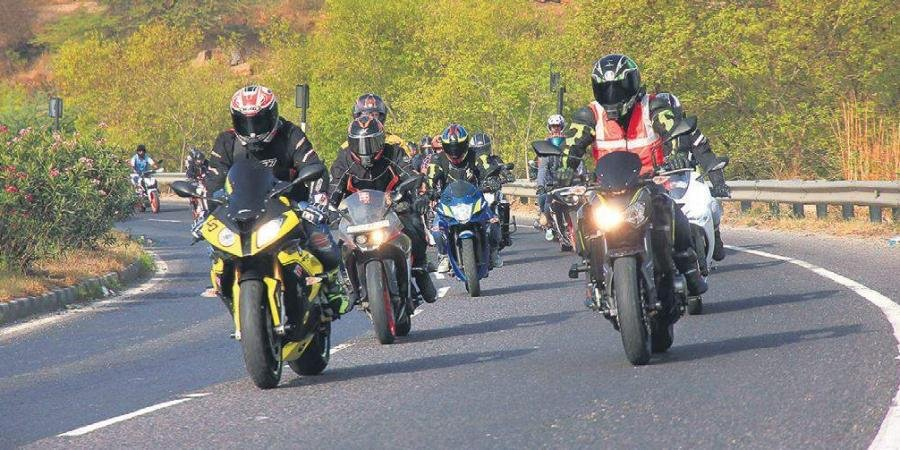

In [149]:
test_img = Image.open(imlabel_list[0][0])
test_img_arr = np.array(test_img)
print("Original dimensions: ",test_img_arr.shape)
test_img

Updated dimensions:  (544, 960, 3)


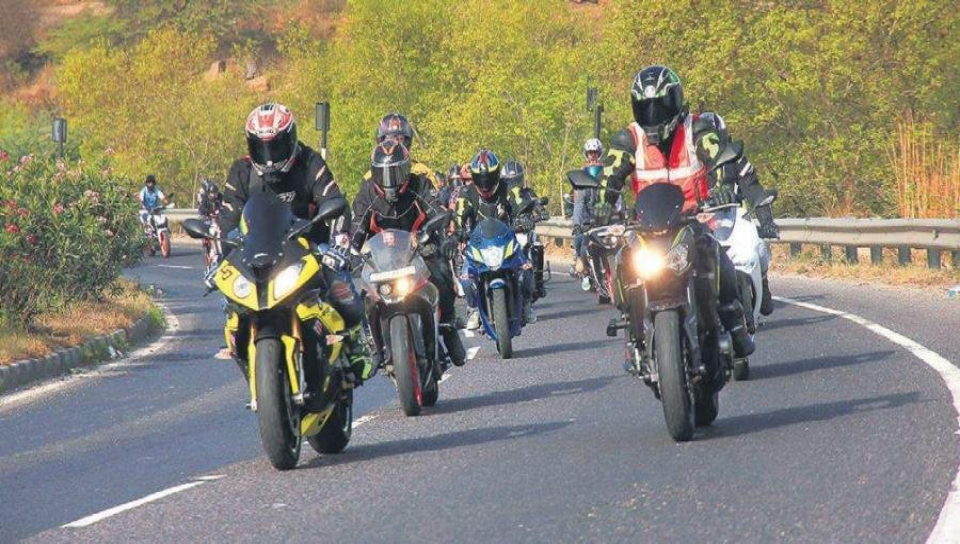

In [150]:
img_arr, bboxes = resize_img_bbox((imlabel_list[0][0],imlabel_list[0][1]), (960,544))
# im_rgb_test = cv2.cvtColor(img_arr.astype('float32'), cv2.COLOR_BGR2RGB)
Image.fromarray(conv2uint8(img_arr))

In [151]:
testing_info = {
    'newimg_path': 'data/kitti/custom_annotated/resized/images/2-wheeler-1_resized',
    'image_arr': img_arr,
    'newlabel_path': 'data/kitti/custom_annotated/resized/labels/2-wheeler-1_resized',
    'origlabel_path': imlabel_list[0][1],
    'img_bboxes': bboxes
}

save_newimgdata(testing_info)

In [152]:
os.path.basename(imlabel_list[0][0])[:-4]

'2-wheeler-1'

In [153]:
newimgdir = 'data/kitti/custom_annotated/resized/images/'
newlbdir = 'data/kitti/custom_annotated/resized/labels/'
dim = (960,544)
resizeimg_info = {}

for item in imlabel_list:
    resize_imgname = os.path.basename(item[0])[:-4] + '_resized'
    resize_lbboxnm = os.path.basename(item[1])[:-4] + '_resized'
    resizeimg_info['image_arr'], resizeimg_info['img_bboxes'] = resize_img_bbox((item[0],item[1]),dim)
    resizeimg_info['newimg_path'] = newimgdir + resize_imgname
    resizeimg_info['newlabel_path'] = newlbdir + resize_lbboxnm
    resizeimg_info['origlabel_path'] = item[1]
    
    save_newimgdata(resizeimg_info)

Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)


In [36]:
# For Spatial Augmentation
class Spatial_Aug:
    def __init__(self, image_path, label_path):
        self.image_arr = cv2.imread(image_path)/255
        # Convert to rgb float32, as opencv only works with float32
        self.image_arr = cv2.cvtColor(self.image_arr.astype("float32"), cv2.COLOR_BGR2RGB)
        self.bboxes = fetch_bboxes(label_path)
        
    def hflip (self):
        # Fetching image width
        image_width = np.array(self.image_arr.shape[:2])[::-1][0]
        # Horizontally stacking image width for further perusal
        image_width = np.hstack((image_width, image_width))
        # Reversing the image co-ordinates in the 1st dimension
        # i.e Hz_flipping the image
        self.image_arr = self.image_arr[:,::-1,:]
        # Calculating the new distance from origin
        self.bboxes[:,[0,2]] = image_width - self.bboxes[:,[0,2]]
        # Interchanging  x1,x2 co-ordinates
        # Method 1: Calculating the bbox width
        box_width = abs(self.bboxes[:,0] - self.bboxes[:,2])
        self.bboxes[:,0] -= box_width
        self.bboxes[:,2] += box_width
        # Method 2: Swap co-ordinates
        #bbox_x1 = bboxes[:,0]
        #bboxes[:,0] = bboxes[:,2]
        #bboxes[:,1] = bbox_x1
        
        #return self.image_arr,self.bboxes
        return self
    
    def translate (self, TxTy = (8,8)):
        rows,cols = self.image_arr.shape[:2]
        # Making a transition matrix
        # Here the shift is Tx=Ty=8
        Tx,Ty = TxTy
        rand_x = gen_rand_num(0,Tx)
        rand_y = gen_rand_num(0,Ty)
        M = np.float32([[1,0,rand_x],[0,1,rand_y]])
        self.image_arr = cv2.warpAffine(self.image_arr,M,(cols,rows))
        self.bboxes[:,[0,2]] += rand_x
        self.bboxes[:,[1,3]] += rand_y
        return self

In [37]:
# For Color Augmentation
class Color_Aug:
    def __init__(self, image_path, label_path):
        self.image_arr = cv2.imread(image_path)/255
        self.image_arr = cv2.cvtColor(self.image_arr.astype("float32"), cv2.COLOR_BGR2RGB)
        self.bboxes = fetch_bboxes(label_path)
    
    # definition to rotate hue of image
    def hue_rotate(self, hue_rot_max=0.5):    
        hsv = color.rgb2hsv(color.gray2rgb(self.image_arr))
        rand_hue_rot = gen_rand_num(0.1,hue_rot_max)
        #print("rand_hue_rot = ",rand_hue_rot)
        hsv[:, :, 0] = rand_hue_rot # adjust hue
        hsv[:, :, 1] = 1  # Turn up the saturation
        #return color.hsv2rgb(hsv)
        self.image_arr = color.hsv2rgb(hsv)
        return self
    
    """# defintion to adjust saturation
    def saturation(self, factor):
        rand_fact = gen_rand_num(0,factor)
        converter = ImageEnhance.Color(self.image)
        return converter.enhance(rand_fact)"""
    
    def saturation (self, factor=1.5):
        #imghsv = color.rgb2hsv(self.image_arr)
        imghsv = cv2.cvtColor(self.image_arr.astype("float32"), cv2.COLOR_BGR2HSV)
        (h, s, v) = cv2.split(imghsv)
        factor = gen_rand_num(0.1,factor)
        # print("Random Factor = ",factor)
        s = s*factor
        s = np.clip(s,0,1)
        imghsv = cv2.merge([h,s,v])
        imgrgb = cv2.cvtColor(imghsv.astype("float32"), cv2.COLOR_HSV2BGR)
        self.image_arr = imgrgb
        return self
    
    """def contrast_scale(self, factor):
        factor = gen_rand_num(0.2,factor)
        imghsv = cv2.cvtColor(self.image_arr.astype("float32"), cv2.COLOR_BGR2HSV)
        imghsv = cv2.convertScaleAbs(self.image_arr, alpha=factor, beta=0)
        imgrgb = cv2.cvtColor(imghsv.astype("float32"), cv2.COLOR_HSV2BGR)
        return imgrgb"""
    def brightness (self, factor=1.5):
        imghsv = cv2.cvtColor(self.image_arr.astype("float32"), cv2.COLOR_BGR2HSV)
        (h, s, v) = cv2.split(imghsv)
        factor = gen_rand_num(0.8,factor)
        # print("Random Factor = ",factor)
        v = v*factor
        v = np.clip(v,0,1)
        imghsv = cv2.merge([h,s,v])
        imgrgb = cv2.cvtColor(imghsv.astype("float32"), cv2.COLOR_HSV2BGR)
        self.image_arr = imgrgb
        return self       

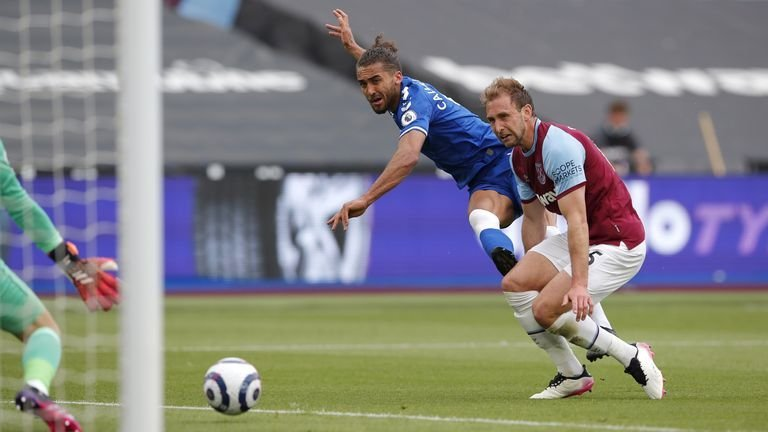

In [156]:
# Test code to fetch bounding boxes and image
from PIL import Image
image = Image.open('sports.jpg')
image

In [157]:
im_cv2 = cv2.imread('sports.jpg')
# im_cv2 = cv2.imread('sports.jpg')
# cv2.imwrite('cv2_test.jpg', im_cv2)

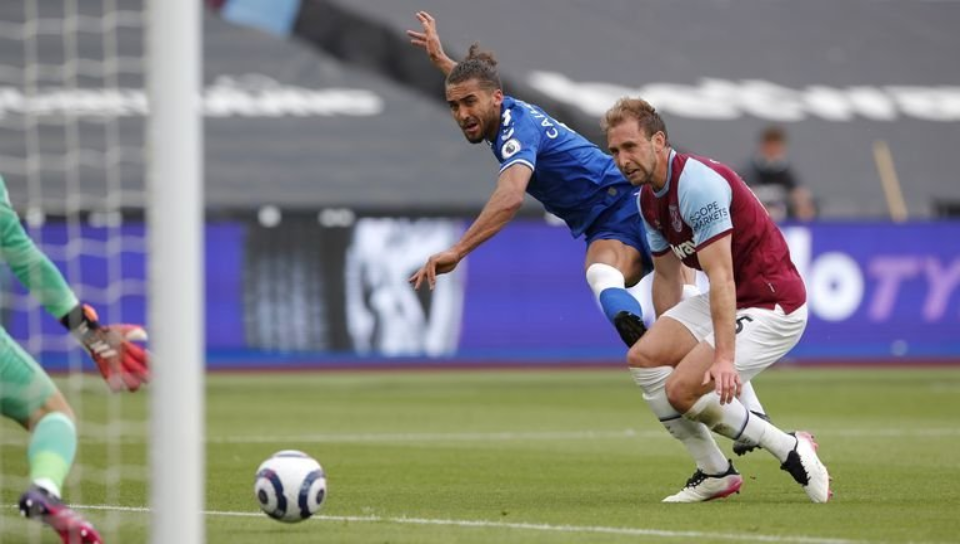

In [158]:
im_cv2 = cv2.resize(im_cv2, (960,544))
# im_cv2 = cv2.cvtColor(im_cv2, cv2.COLOR_BGR2RGB)
im_rgb = cv2.cvtColor(im_cv2, cv2.COLOR_BGR2RGB)
Image.fromarray(im_rgb)

In [159]:
cv2.imwrite('sports_cv2.jpg', im_cv2)

True

In [160]:
# Draw bbox on image
# Ref from Paperspace blog
def draw_bbox(img, cords, color = None):
    """Draw the rectangle on the image
    
    Parameters
    ----------
    
    img : numpy.ndarray
        numpy image 
    
    cords: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    Returns
    -------
    
    numpy.ndarray
        numpy image with bounding boxes drawn on it
        
    """    
    img = img.copy()
    
    cords = cords.reshape(-1,4)
    if not color:
        color = [255,255,255]
    for cord in cords:
        
        pt1, pt2 = (cord[0], cord[1]) , (cord[2], cord[3])
                
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
    
        img = cv2.rectangle(img, pt1, pt2, color, int(max(img.shape[:2])/200))
    return img

In [161]:
bboxes = fetch_bboxes('/workspace/experiment/' + 'sports.txt')
bboxes

array([[315.,   6., 514., 403.,   0.],
       [479.,  76., 667., 412.,   0.],
       [196., 348., 269., 423.,   0.]])

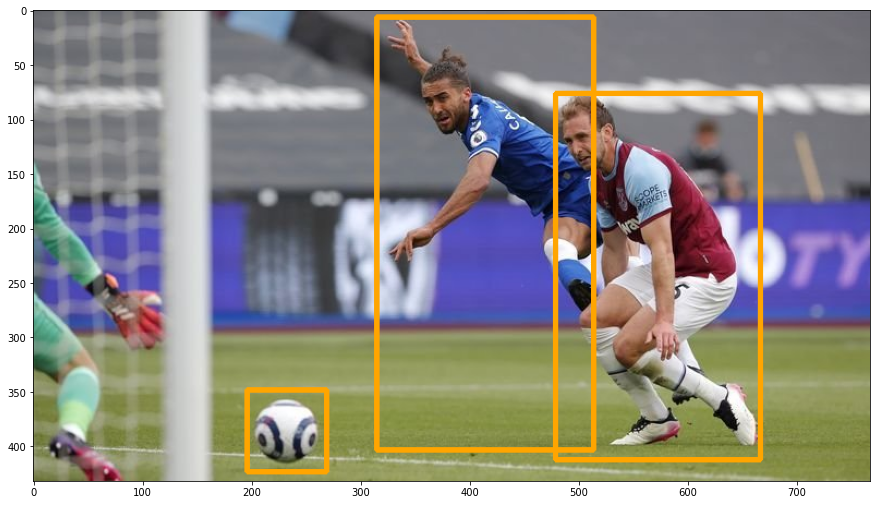

In [162]:
bbox_img = Image.fromarray(draw_bbox(np.asarray(image),
                                     bboxes[:,:4], color=[255,165,0]))
plt.imshow(bbox_img)

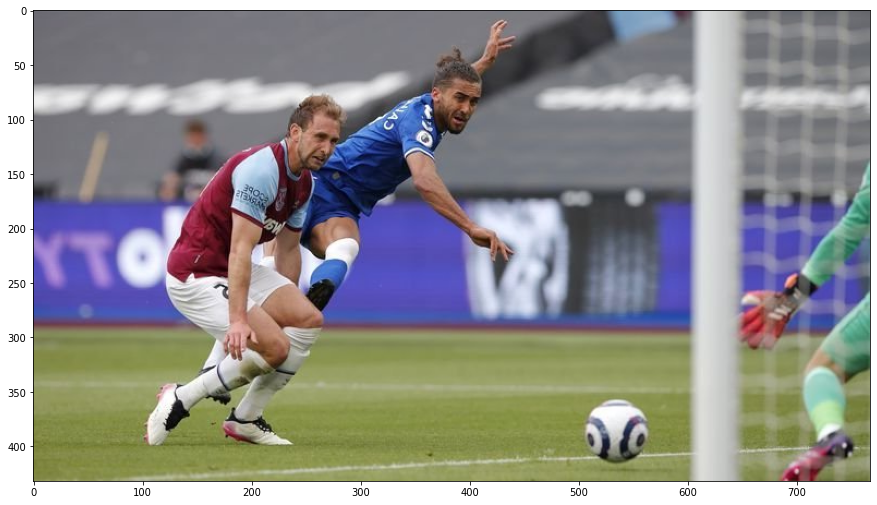

In [163]:
plt.imshow(Image.fromarray(np.asarray(image)[:,::-1,:]))

In [164]:
spat_aug = Spatial_Aug(image_path='/workspace/experiment/' + 'sports.jpg', 
                       label_path='/workspace/experiment/' + 'sports.txt')
print("Image shape: ", spat_aug.image_arr.shape)
print("Image bboxes:\n-------------------------------------------------\n",spat_aug.bboxes)
spat_aug = spat_aug.hflip()

Image shape:  (432, 768, 3)
Image bboxes:
-------------------------------------------------
 [[315.   6. 514. 403.   0.]
 [479.  76. 667. 412.   0.]
 [196. 348. 269. 423.   0.]]


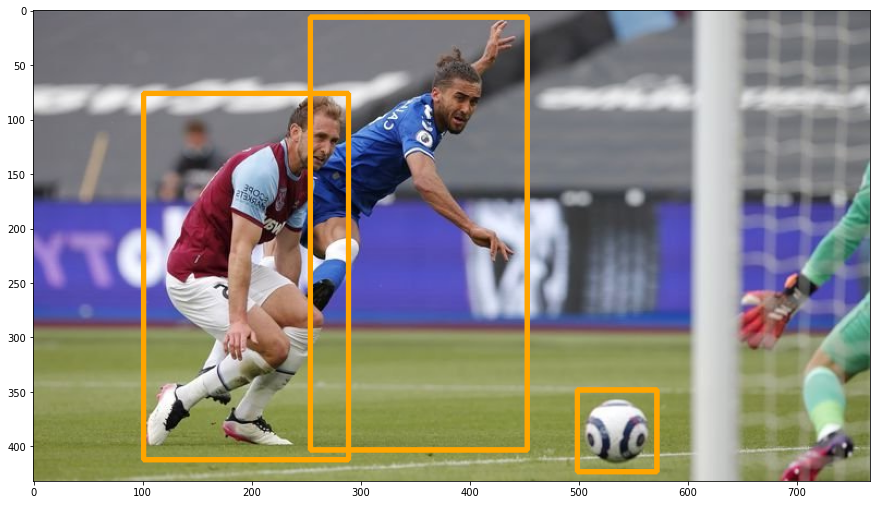

In [165]:
# spat_aug_rgb = cv2.cvtColor(spat_aug.image_arr.astype("float32"), cv2.COLOR_BGR2RGB)
bbox_flipim = Image.fromarray(draw_bbox(conv2uint8(spat_aug.image_arr),
                                     spat_aug.bboxes[:,:4], color=[255,165,0]))
plt.imshow(bbox_flipim)

In [166]:
cv2.imwrite('sports_cv2_aug.jpg', conv2uint8(spat_aug.image_arr))

True

In [167]:
print("Bounding boxes before translation:\n", spat_aug.bboxes)
spat_aug_shift = Spatial_Aug(image_path='/workspace/experiment/' + 'sports.jpg', 
                       label_path='/workspace/experiment/' + 'sports.txt')
spat_aug_shift = spat_aug_shift.translate((8,8))
print("\n10th index of augmented image array:\n", spat_aug_shift.image_arr[10])
print("\nBounding boxes after translation:\n", spat_aug_shift.bboxes)

Bounding boxes before translation:
 [[254.   6. 453. 403.   0.]
 [101.  76. 289. 412.   0.]
 [499. 348. 572. 423.   0.]]

10th index of augmented image array:
 [[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 ...
 [0.4197304  0.41580883 0.44718137]
 [0.4197304  0.41580883 0.44718137]
 [0.4197304  0.41580883 0.44718137]]

Bounding boxes after translation:
 [[322.5671311    8.95897026 521.5671311  405.95897026   0.        ]
 [486.5671311   78.95897026 674.5671311  414.95897026   0.        ]
 [203.5671311  350.95897026 276.5671311  425.95897026   0.        ]]


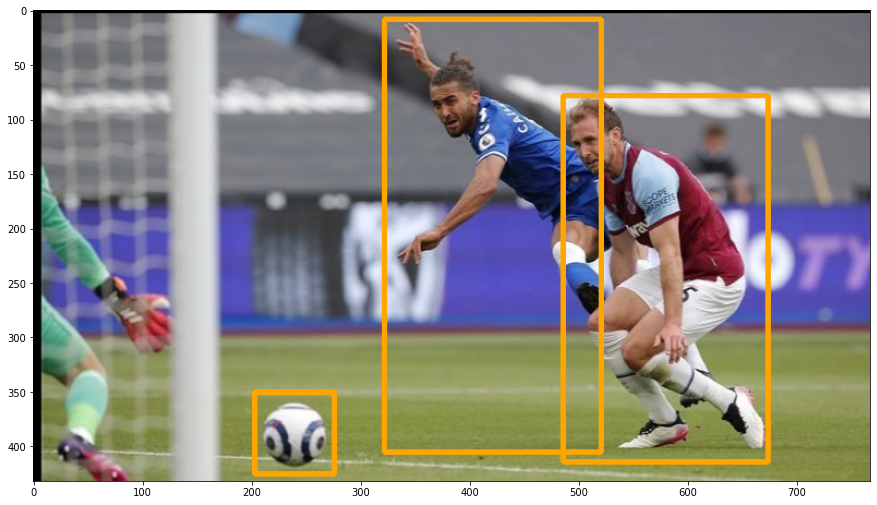

In [168]:
shfbbox_img = Image.fromarray(draw_bbox(conv2uint8(spat_aug_shift.image_arr),
                                     spat_aug_shift.bboxes[:,:4], color=[255,165,0]))
plt.imshow(shfbbox_img)

In [169]:
image_path = '/workspace/experiment/' + 'sports.jpg'
label_path = '/workspace/experiment/' + 'sports.txt'
col_aug = Color_Aug(image_path=image_path, label_path=label_path)
col_aug.image_arr[0]

array([[0.39607844, 0.4       , 0.41960785],
       [0.39607844, 0.4       , 0.41960785],
       [0.39607844, 0.4       , 0.41960785],
       ...,
       [0.45490196, 0.4509804 , 0.48235294],
       [0.45490196, 0.4509804 , 0.48235294],
       [0.45490196, 0.4509804 , 0.48235294]], dtype=float32)

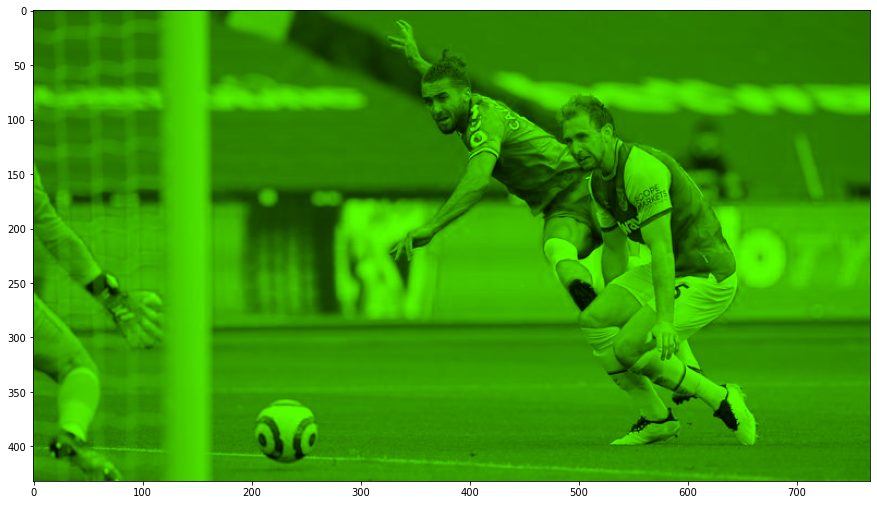

In [170]:
hue_img = col_aug.hue_rotate(0.5)
plt.imshow(Image.fromarray(conv2uint8(hue_img.image_arr)))

In [171]:
np.array(hue_img.image_arr)[0]

array([[0.14442258, 0.41960785, 0.        ],
       [0.14442258, 0.41960785, 0.        ],
       [0.14442258, 0.41960785, 0.        ],
       ...,
       [0.16601847, 0.48235294, 0.        ],
       [0.16601847, 0.48235294, 0.        ],
       [0.16601847, 0.48235294, 0.        ]], dtype=float32)

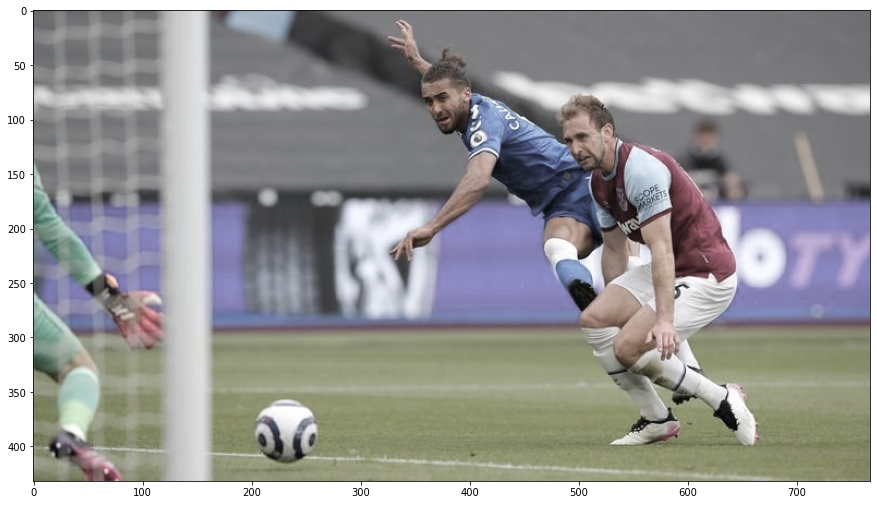

In [172]:
image_path = '/workspace/experiment/' + 'sports.jpg'
label_path = '/workspace/experiment/' + 'sports.txt'
col_aug = Color_Aug(image_path=image_path, label_path=label_path)
sat_img = col_aug.saturation(1.5)
plt.imshow(Image.fromarray(conv2uint8(sat_img.image_arr)))

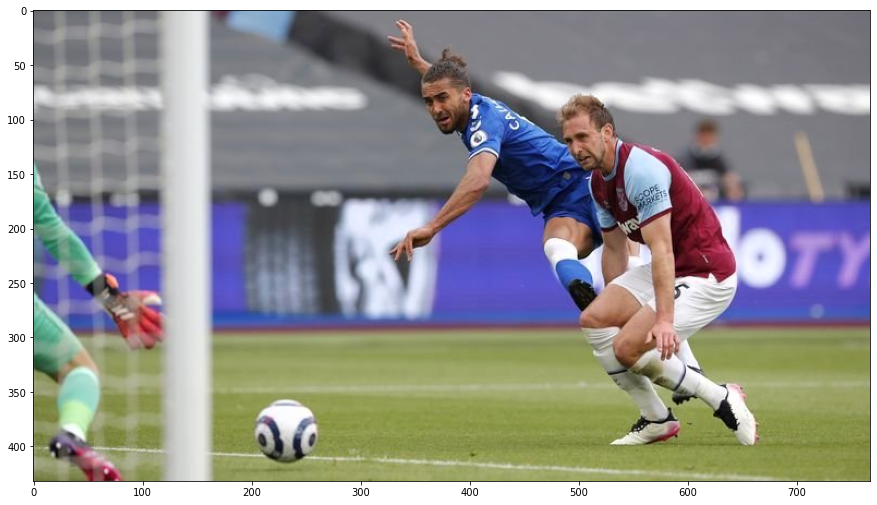

In [173]:
image_path = '/workspace/experiment/' + 'sports.jpg'
label_path = '/workspace/experiment/' + 'sports.txt'
col_aug = Color_Aug(image_path=image_path, label_path=label_path)
con_scale_img = col_aug.brightness(1.2)
plt.imshow(Image.fromarray(conv2uint8(con_scale_img.image_arr)))

In [174]:
impath = 'data/kitti/custom_annotated/resized/images/'
labels_path = 'data/kitti/custom_annotated/resized/labels/'
imlabel_list = imlabel(impath=impath,
                      labels_path=labels_path)
imlabel_list[5]

('data/kitti/custom_annotated/resized/images/2-wheeler-5_resized.jpg',
 'data/kitti/custom_annotated/resized/labels/2-wheeler-5_resized.txt')

In [38]:
# Randomizing augmentation class and type choice
spat_aug_dict = {
    'class' : Spatial_Aug,
    0 : 'hflip',
    1 : 'translate'
}

color_aug_dict = {
    'class' : Color_Aug,
    0 : 'hue_rotate',
    1 : 'saturation',
    2:  'brightness'
}

aug_classes = [spat_aug_dict, color_aug_dict]

In [176]:
image_info = {}
for i in range(0,2):
    for item in imlabel_list:
        print("Image File", item[0])
        # get the aug class
        aug_class = int(gen_rand_num(0,2))
        # get aug type
        num_types = len(aug_classes[aug_class]) - 1
        aug_type = int(gen_rand_num(0,num_types))
        # create aug class obj
        aug_class_obj = aug_classes[aug_class]['class'](item[0],item[1])
        # augment image_bbox object
        # aug_class_obj = aug_class_obj.aug_classes[aug_class][aug_type]
        # use get_attr to dynamically fetch the class method
        aug_class_method = getattr(aug_class_obj,aug_classes[aug_class][aug_type])
        # call the aug_type class method
        aug_class_obj = aug_class_method()
        # Fetching image, label names
        augimg_name = os.path.basename(item[0])[:-4] + '_'  + aug_classes[aug_class][aug_type]
        auglabel_name = os.path.basename(item[1])[:-4] + '_' + aug_classes[aug_class][aug_type]
        # Store image info in dictionary
        augimg_path = 'data/kitti/augmented_test/images/' + augimg_name
        auglabel_path = 'data/kitti/augmented_test/labels/' + auglabel_name
        origlabel_path = item[1]
        
        image_info['newimg_path'] = augimg_path
        image_info['newlabel_path'] = auglabel_path
        image_info['origlabel_path'] = origlabel_path
        image_info['img_bboxes'] = aug_class_obj.bboxes
        image_info['image_arr'] = aug_class_obj.image_arr
        
        save_newimgdata(image_info)

Image File data/kitti/custom_annotated/resized/images/2-wheeler-10_resized.jpg
Image File data/kitti/custom_annotated/resized/images/2-wheeler-1_resized.jpg
Image File data/kitti/custom_annotated/resized/images/2-wheeler-2_resized.jpg
Image File data/kitti/custom_annotated/resized/images/2-wheeler-3_resized.jpg
Image File data/kitti/custom_annotated/resized/images/2-wheeler-4_resized.jpg
Image File data/kitti/custom_annotated/resized/images/2-wheeler-5_resized.jpg
Image File data/kitti/custom_annotated/resized/images/2-wheeler-6_resized.jpg
Image File data/kitti/custom_annotated/resized/images/2-wheeler-7_resized.jpg
Image File data/kitti/custom_annotated/resized/images/2-wheeler-8_resized.jpg
Image File data/kitti/custom_annotated/resized/images/2-wheeler-9_resized.jpg
Image File data/kitti/custom_annotated/resized/images/2-wheeler_resized.jpg
Image File data/kitti/custom_annotated/resized/images/pedestrian_0_resized.jpg
Image File data/kitti/custom_annotated/resized/images/pedestrian

In [177]:
""""test_obj = Spatial_Aug('data/kitti/annotated_images/2-wheeler-1.jpg', 'data/kitti/labels/2-wheeler-1.txt')
test_method = getattr(test_obj, spat_aug_dict[0])
test_method
myobj = test_method()"""

'"test_obj = Spatial_Aug(\'data/kitti/annotated_images/2-wheeler-1.jpg\', \'data/kitti/labels/2-wheeler-1.txt\')\ntest_method = getattr(test_obj, spat_aug_dict[0])\ntest_method\nmyobj = test_method()'

### Integrating the workflow for original KITTI dataset

In [47]:
# Resize Workflow
def resize_dataset(imlabel_list, newimgdir, newlbdir):
    dim = (960,544)
    resizeimg_info = {}

    for item,bar in zip(imlabel_list,tqnb(range(len(imlabel_list)),desc='Resizing Images')):
        resize_imgname = os.path.basename(item[0])[:-4] + '_resized'
        resize_lbboxnm = os.path.basename(item[1])[:-4] + '_resized'
        resizeimg_info['image_arr'], resizeimg_info['img_bboxes'] = resize_img_bbox((item[0],item[1]),dim)
        resizeimg_info['newimg_path'] = newimgdir + resize_imgname
        resizeimg_info['newlabel_path'] = newlbdir + resize_lbboxnm
        resizeimg_info['origlabel_path'] = item[1]

        save_newimgdata(resizeimg_info)
        time.sleep(0.000015)
# random start, end indices to be used for augmentation        
def start_end(start, diff, lends):
    end = start + diff
    if end > lends:
        newdiff = end - lends
        start = start - newdiff
        end = start + diff
    return start,end
    
# Augmentation Workflow
def aug_dataset(imlabel_list, img_path, label_path):
    image_info = {}
    
    lends = len(imlabel_list)
    diff = 2000
    randnum = int(gen_rand_num(0,lends))
    start,end = start_end(randnum,diff,lends)
    
    for i in range(0,2):
        for item,bar in zip(imlabel_list[start:end],
                            tqnb(range(len(imlabel_list[start:end])),desc='Augmenting Images')):
            print("Image File", item[0])
            # get the aug class
            aug_class = int(gen_rand_num(0,2))
            # get aug type
            num_types = len(aug_classes[aug_class]) - 1
            aug_type = int(gen_rand_num(0,num_types))
            # create aug class obj
            aug_class_obj = aug_classes[aug_class]['class'](item[0],item[1])
            # augment image_bbox object
            # aug_class_obj = aug_class_obj.aug_classes[aug_class][aug_type]
            # use get_attr to dynamically fetch the class method
            aug_class_method = getattr(aug_class_obj,aug_classes[aug_class][aug_type])
            # call the aug_type class method
            aug_class_obj = aug_class_method()
            # Fetching image, label names
            augimg_name = os.path.basename(item[0])[:-4] + '_'  + aug_classes[aug_class][aug_type]
            auglabel_name = os.path.basename(item[1])[:-4] + '_' + aug_classes[aug_class][aug_type]
            # Store image info in dictionary
            augimg_path = img_path + augimg_name
            auglabel_path = label_path + auglabel_name
            origlabel_path = item[1]

            image_info['newimg_path'] = augimg_path
            image_info['newlabel_path'] = auglabel_path
            image_info['origlabel_path'] = origlabel_path
            image_info['img_bboxes'] = aug_class_obj.bboxes
            image_info['image_arr'] = aug_class_obj.image_arr

            save_newimgdata(image_info)
            time.sleep(0.00095)

In [49]:
# Fetch image and label path of dataset
impath = 'data/kitti/integration/original/training/image_2/'
labels_path = 'data/kitti/integration/original/training/label_2/'
imlabel_list = imlabel(impath, labels_path)
# testimpath = 'data/kitti/integration/original/testing/image_2/'
# testresizepath = 'data/kitti/integration/resized/testing/images/'
# testimgs = sorted(os.listdir(testimpath))
# for testimg,bar in zip(testimgs,tqnb(range(len(testimgs))):
    # just_resize_save(testimpath + testimg,testresizepath,(960,544))
    # time.sleep(0.1)
# Resize image and bboxes
newimgdir = 'data/kitti/integration/resized/training/images/'
newlbdir = 'data/kitti/integration/resized/training/labels/'
resize_dataset(imlabel_list, newimgdir, newlbdir)
# Augment image and bboxes
impath = 'data/kitti/integration/resized/training/images/'
labels_path = 'data/kitti/integration/resized/training/labels/'
imlabel_list = imlabel(newimgdir, newlbdir)
aug_dataset(imlabel_list, impath, labels_path)

Image File data/kitti/integration/resized/training/images/003088_resized.jpg
Image File data/kitti/integration/resized/training/images/003089_resized.jpg
Image File data/kitti/integration/resized/training/images/003090_resized.jpg
Image File data/kitti/integration/resized/training/images/003091_resized.jpg
Image File data/kitti/integration/resized/training/images/003092_resized.jpg
Image File data/kitti/integration/resized/training/images/003093_resized.jpg
Image File data/kitti/integration/resized/training/images/003094_resized.jpg
Image File data/kitti/integration/resized/training/images/003095_resized.jpg
Image File data/kitti/integration/resized/training/images/003096_resized.jpg
Image File data/kitti/integration/resized/training/images/003097_resized.jpg
Image File data/kitti/integration/resized/training/images/003098_resized.jpg
Image File data/kitti/integration/resized/training/images/003099_resized.jpg
Image File data/kitti/integration/resized/training/images/003100_resized.jpg

Image File data/kitti/integration/resized/training/images/003196_resized.jpg
Image File data/kitti/integration/resized/training/images/003197_resized.jpg
Image File data/kitti/integration/resized/training/images/003198_resized.jpg
Image File data/kitti/integration/resized/training/images/003199_resized.jpg
Image File data/kitti/integration/resized/training/images/003200_resized.jpg
Image File data/kitti/integration/resized/training/images/003201_resized.jpg
Image File data/kitti/integration/resized/training/images/003202_resized.jpg
Image File data/kitti/integration/resized/training/images/003203_resized.jpg
Image File data/kitti/integration/resized/training/images/003204_resized.jpg
Image File data/kitti/integration/resized/training/images/003205_resized.jpg
Image File data/kitti/integration/resized/training/images/003206_resized.jpg
Image File data/kitti/integration/resized/training/images/003207_resized.jpg
Image File data/kitti/integration/resized/training/images/003208_resized.jpg

Image File data/kitti/integration/resized/training/images/003308_resized.jpg
Image File data/kitti/integration/resized/training/images/003309_resized.jpg
Image File data/kitti/integration/resized/training/images/003310_resized.jpg
Image File data/kitti/integration/resized/training/images/003311_resized.jpg
Image File data/kitti/integration/resized/training/images/003312_resized.jpg
Image File data/kitti/integration/resized/training/images/003313_resized.jpg
Image File data/kitti/integration/resized/training/images/003314_resized.jpg
Image File data/kitti/integration/resized/training/images/003315_resized.jpg
Image File data/kitti/integration/resized/training/images/003316_resized.jpg
Image File data/kitti/integration/resized/training/images/003317_resized.jpg
Image File data/kitti/integration/resized/training/images/003318_resized.jpg
Image File data/kitti/integration/resized/training/images/003319_resized.jpg
Image File data/kitti/integration/resized/training/images/003320_resized.jpg

Image File data/kitti/integration/resized/training/images/003419_resized.jpg
Image File data/kitti/integration/resized/training/images/003420_resized.jpg
Image File data/kitti/integration/resized/training/images/003421_resized.jpg
Image File data/kitti/integration/resized/training/images/003422_resized.jpg
Image File data/kitti/integration/resized/training/images/003423_resized.jpg
Image File data/kitti/integration/resized/training/images/003424_resized.jpg
Image File data/kitti/integration/resized/training/images/003425_resized.jpg
Image File data/kitti/integration/resized/training/images/003426_resized.jpg
Image File data/kitti/integration/resized/training/images/003427_resized.jpg
Image File data/kitti/integration/resized/training/images/003428_resized.jpg
Image File data/kitti/integration/resized/training/images/003429_resized.jpg
Image File data/kitti/integration/resized/training/images/003430_resized.jpg
Image File data/kitti/integration/resized/training/images/003431_resized.jpg

Image File data/kitti/integration/resized/training/images/003526_resized.jpg
Image File data/kitti/integration/resized/training/images/003527_resized.jpg
Image File data/kitti/integration/resized/training/images/003528_resized.jpg
Image File data/kitti/integration/resized/training/images/003529_resized.jpg
Image File data/kitti/integration/resized/training/images/003530_resized.jpg
Image File data/kitti/integration/resized/training/images/003531_resized.jpg
Image File data/kitti/integration/resized/training/images/003532_resized.jpg
Image File data/kitti/integration/resized/training/images/003533_resized.jpg
Image File data/kitti/integration/resized/training/images/003534_resized.jpg
Image File data/kitti/integration/resized/training/images/003535_resized.jpg
Image File data/kitti/integration/resized/training/images/003536_resized.jpg
Image File data/kitti/integration/resized/training/images/003537_resized.jpg
Image File data/kitti/integration/resized/training/images/003538_resized.jpg

Image File data/kitti/integration/resized/training/images/003639_resized.jpg
Image File data/kitti/integration/resized/training/images/003640_resized.jpg
Image File data/kitti/integration/resized/training/images/003641_resized.jpg
Image File data/kitti/integration/resized/training/images/003642_resized.jpg
Image File data/kitti/integration/resized/training/images/003643_resized.jpg
Image File data/kitti/integration/resized/training/images/003644_resized.jpg
Image File data/kitti/integration/resized/training/images/003645_resized.jpg
Image File data/kitti/integration/resized/training/images/003646_resized.jpg
Image File data/kitti/integration/resized/training/images/003647_resized.jpg
Image File data/kitti/integration/resized/training/images/003648_resized.jpg
Image File data/kitti/integration/resized/training/images/003649_resized.jpg
Image File data/kitti/integration/resized/training/images/003650_resized.jpg
Image File data/kitti/integration/resized/training/images/003651_resized.jpg

Image File data/kitti/integration/resized/training/images/003747_resized.jpg
Image File data/kitti/integration/resized/training/images/003748_resized.jpg
Image File data/kitti/integration/resized/training/images/003749_resized.jpg
Image File data/kitti/integration/resized/training/images/003750_resized.jpg
Image File data/kitti/integration/resized/training/images/003751_resized.jpg
Image File data/kitti/integration/resized/training/images/003752_resized.jpg
Image File data/kitti/integration/resized/training/images/003753_resized.jpg
Image File data/kitti/integration/resized/training/images/003754_resized.jpg
Image File data/kitti/integration/resized/training/images/003755_resized.jpg
Image File data/kitti/integration/resized/training/images/003756_resized.jpg
Image File data/kitti/integration/resized/training/images/003757_resized.jpg
Image File data/kitti/integration/resized/training/images/003758_resized.jpg
Image File data/kitti/integration/resized/training/images/003759_resized.jpg

Image File data/kitti/integration/resized/training/images/003860_resized.jpg
Image File data/kitti/integration/resized/training/images/003861_resized.jpg
Image File data/kitti/integration/resized/training/images/003862_resized.jpg
Image File data/kitti/integration/resized/training/images/003863_resized.jpg
Image File data/kitti/integration/resized/training/images/003864_resized.jpg
Image File data/kitti/integration/resized/training/images/003865_resized.jpg
Image File data/kitti/integration/resized/training/images/003866_resized.jpg
Image File data/kitti/integration/resized/training/images/003867_resized.jpg
Image File data/kitti/integration/resized/training/images/003868_resized.jpg
Image File data/kitti/integration/resized/training/images/003869_resized.jpg
Image File data/kitti/integration/resized/training/images/003870_resized.jpg
Image File data/kitti/integration/resized/training/images/003871_resized.jpg
Image File data/kitti/integration/resized/training/images/003872_resized.jpg

Image File data/kitti/integration/resized/training/images/003970_resized.jpg
Image File data/kitti/integration/resized/training/images/003971_resized.jpg
Image File data/kitti/integration/resized/training/images/003972_resized.jpg
Image File data/kitti/integration/resized/training/images/003973_resized.jpg
Image File data/kitti/integration/resized/training/images/003974_resized.jpg
Image File data/kitti/integration/resized/training/images/003975_resized.jpg
Image File data/kitti/integration/resized/training/images/003976_resized.jpg
Image File data/kitti/integration/resized/training/images/003977_resized.jpg
Image File data/kitti/integration/resized/training/images/003978_resized.jpg
Image File data/kitti/integration/resized/training/images/003979_resized.jpg
Image File data/kitti/integration/resized/training/images/003980_resized.jpg
Image File data/kitti/integration/resized/training/images/003981_resized.jpg
Image File data/kitti/integration/resized/training/images/003982_resized.jpg

Image File data/kitti/integration/resized/training/images/004078_resized.jpg
Image File data/kitti/integration/resized/training/images/004079_resized.jpg
Image File data/kitti/integration/resized/training/images/004080_resized.jpg
Image File data/kitti/integration/resized/training/images/004081_resized.jpg
Image File data/kitti/integration/resized/training/images/004082_resized.jpg
Image File data/kitti/integration/resized/training/images/004083_resized.jpg
Image File data/kitti/integration/resized/training/images/004084_resized.jpg
Image File data/kitti/integration/resized/training/images/004085_resized.jpg
Image File data/kitti/integration/resized/training/images/004086_resized.jpg
Image File data/kitti/integration/resized/training/images/004087_resized.jpg
Image File data/kitti/integration/resized/training/images/004088_resized.jpg
Image File data/kitti/integration/resized/training/images/004089_resized.jpg
Image File data/kitti/integration/resized/training/images/004090_resized.jpg

Image File data/kitti/integration/resized/training/images/004193_resized.jpg
Image File data/kitti/integration/resized/training/images/004194_resized.jpg
Image File data/kitti/integration/resized/training/images/004195_resized.jpg
Image File data/kitti/integration/resized/training/images/004196_resized.jpg
Image File data/kitti/integration/resized/training/images/004197_resized.jpg
Image File data/kitti/integration/resized/training/images/004198_resized.jpg
Image File data/kitti/integration/resized/training/images/004199_resized.jpg
Image File data/kitti/integration/resized/training/images/004200_resized.jpg
Image File data/kitti/integration/resized/training/images/004201_resized.jpg
Image File data/kitti/integration/resized/training/images/004202_resized.jpg
Image File data/kitti/integration/resized/training/images/004203_resized.jpg
Image File data/kitti/integration/resized/training/images/004204_resized.jpg
Image File data/kitti/integration/resized/training/images/004205_resized.jpg

Image File data/kitti/integration/resized/training/images/004300_resized.jpg
Image File data/kitti/integration/resized/training/images/004301_resized.jpg
Image File data/kitti/integration/resized/training/images/004302_resized.jpg
Image File data/kitti/integration/resized/training/images/004303_resized.jpg
Image File data/kitti/integration/resized/training/images/004304_resized.jpg
Image File data/kitti/integration/resized/training/images/004305_resized.jpg
Image File data/kitti/integration/resized/training/images/004306_resized.jpg
Image File data/kitti/integration/resized/training/images/004307_resized.jpg
Image File data/kitti/integration/resized/training/images/004308_resized.jpg
Image File data/kitti/integration/resized/training/images/004309_resized.jpg
Image File data/kitti/integration/resized/training/images/004310_resized.jpg
Image File data/kitti/integration/resized/training/images/004311_resized.jpg
Image File data/kitti/integration/resized/training/images/004312_resized.jpg

Image File data/kitti/integration/resized/training/images/004409_resized.jpg
Image File data/kitti/integration/resized/training/images/004410_resized.jpg
Image File data/kitti/integration/resized/training/images/004411_resized.jpg
Image File data/kitti/integration/resized/training/images/004412_resized.jpg
Image File data/kitti/integration/resized/training/images/004413_resized.jpg
Image File data/kitti/integration/resized/training/images/004414_resized.jpg
Image File data/kitti/integration/resized/training/images/004415_resized.jpg
Image File data/kitti/integration/resized/training/images/004416_resized.jpg
Image File data/kitti/integration/resized/training/images/004417_resized.jpg
Image File data/kitti/integration/resized/training/images/004418_resized.jpg
Image File data/kitti/integration/resized/training/images/004419_resized.jpg
Image File data/kitti/integration/resized/training/images/004420_resized.jpg
Image File data/kitti/integration/resized/training/images/004421_resized.jpg

Image File data/kitti/integration/resized/training/images/004522_resized.jpg
Image File data/kitti/integration/resized/training/images/004523_resized.jpg
Image File data/kitti/integration/resized/training/images/004524_resized.jpg
Image File data/kitti/integration/resized/training/images/004525_resized.jpg
Image File data/kitti/integration/resized/training/images/004526_resized.jpg
Image File data/kitti/integration/resized/training/images/004527_resized.jpg
Image File data/kitti/integration/resized/training/images/004528_resized.jpg
Image File data/kitti/integration/resized/training/images/004529_resized.jpg
Image File data/kitti/integration/resized/training/images/004530_resized.jpg
Image File data/kitti/integration/resized/training/images/004531_resized.jpg
Image File data/kitti/integration/resized/training/images/004532_resized.jpg
Image File data/kitti/integration/resized/training/images/004533_resized.jpg
Image File data/kitti/integration/resized/training/images/004534_resized.jpg

Image File data/kitti/integration/resized/training/images/004635_resized.jpg
Image File data/kitti/integration/resized/training/images/004636_resized.jpg
Image File data/kitti/integration/resized/training/images/004637_resized.jpg
Image File data/kitti/integration/resized/training/images/004638_resized.jpg
Image File data/kitti/integration/resized/training/images/004639_resized.jpg
Image File data/kitti/integration/resized/training/images/004640_resized.jpg
Image File data/kitti/integration/resized/training/images/004641_resized.jpg
Image File data/kitti/integration/resized/training/images/004642_resized.jpg
Image File data/kitti/integration/resized/training/images/004643_resized.jpg
Image File data/kitti/integration/resized/training/images/004644_resized.jpg
Image File data/kitti/integration/resized/training/images/004645_resized.jpg
Image File data/kitti/integration/resized/training/images/004646_resized.jpg
Image File data/kitti/integration/resized/training/images/004647_resized.jpg

Image File data/kitti/integration/resized/training/images/004747_resized.jpg
Image File data/kitti/integration/resized/training/images/004748_resized.jpg
Image File data/kitti/integration/resized/training/images/004749_resized.jpg
Image File data/kitti/integration/resized/training/images/004750_resized.jpg
Image File data/kitti/integration/resized/training/images/004751_resized.jpg
Image File data/kitti/integration/resized/training/images/004752_resized.jpg
Image File data/kitti/integration/resized/training/images/004753_resized.jpg
Image File data/kitti/integration/resized/training/images/004754_resized.jpg
Image File data/kitti/integration/resized/training/images/004755_resized.jpg
Image File data/kitti/integration/resized/training/images/004756_resized.jpg
Image File data/kitti/integration/resized/training/images/004757_resized.jpg
Image File data/kitti/integration/resized/training/images/004758_resized.jpg
Image File data/kitti/integration/resized/training/images/004759_resized.jpg

Image File data/kitti/integration/resized/training/images/004855_resized.jpg
Image File data/kitti/integration/resized/training/images/004856_resized.jpg
Image File data/kitti/integration/resized/training/images/004857_resized.jpg
Image File data/kitti/integration/resized/training/images/004858_resized.jpg
Image File data/kitti/integration/resized/training/images/004859_resized.jpg
Image File data/kitti/integration/resized/training/images/004860_resized.jpg
Image File data/kitti/integration/resized/training/images/004861_resized.jpg
Image File data/kitti/integration/resized/training/images/004862_resized.jpg
Image File data/kitti/integration/resized/training/images/004863_resized.jpg
Image File data/kitti/integration/resized/training/images/004864_resized.jpg
Image File data/kitti/integration/resized/training/images/004865_resized.jpg
Image File data/kitti/integration/resized/training/images/004866_resized.jpg
Image File data/kitti/integration/resized/training/images/004867_resized.jpg

Image File data/kitti/integration/resized/training/images/004967_resized.jpg
Image File data/kitti/integration/resized/training/images/004968_resized.jpg
Image File data/kitti/integration/resized/training/images/004969_resized.jpg
Image File data/kitti/integration/resized/training/images/004970_resized.jpg
Image File data/kitti/integration/resized/training/images/004971_resized.jpg
Image File data/kitti/integration/resized/training/images/004972_resized.jpg
Image File data/kitti/integration/resized/training/images/004973_resized.jpg
Image File data/kitti/integration/resized/training/images/004974_resized.jpg
Image File data/kitti/integration/resized/training/images/004975_resized.jpg
Image File data/kitti/integration/resized/training/images/004976_resized.jpg
Image File data/kitti/integration/resized/training/images/004977_resized.jpg
Image File data/kitti/integration/resized/training/images/004978_resized.jpg
Image File data/kitti/integration/resized/training/images/004979_resized.jpg

Image File data/kitti/integration/resized/training/images/005080_resized.jpg
Image File data/kitti/integration/resized/training/images/005081_resized.jpg
Image File data/kitti/integration/resized/training/images/005082_resized.jpg
Image File data/kitti/integration/resized/training/images/005083_resized.jpg
Image File data/kitti/integration/resized/training/images/005084_resized.jpg
Image File data/kitti/integration/resized/training/images/005085_resized.jpg
Image File data/kitti/integration/resized/training/images/005086_resized.jpg
Image File data/kitti/integration/resized/training/images/005087_resized.jpg



Image File data/kitti/integration/resized/training/images/003088_resized.jpg
Image File data/kitti/integration/resized/training/images/003089_resized.jpg
Image File data/kitti/integration/resized/training/images/003090_resized.jpg
Image File data/kitti/integration/resized/training/images/003091_resized.jpg
Image File data/kitti/integration/resized/training/images/003092_resized.jpg
Image File data/kitti/integration/resized/training/images/003093_resized.jpg
Image File data/kitti/integration/resized/training/images/003094_resized.jpg
Image File data/kitti/integration/resized/training/images/003095_resized.jpg
Image File data/kitti/integration/resized/training/images/003096_resized.jpg
Image File data/kitti/integration/resized/training/images/003097_resized.jpg
Image File data/kitti/integration/resized/training/images/003098_resized.jpg
Image File data/kitti/integration/resized/training/images/003099_resized.jpg
Image File data/kitti/integration/resized/training/images/003100_resized.jpg

Image File data/kitti/integration/resized/training/images/003196_resized.jpg
Image File data/kitti/integration/resized/training/images/003197_resized.jpg
Image File data/kitti/integration/resized/training/images/003198_resized.jpg
Image File data/kitti/integration/resized/training/images/003199_resized.jpg
Image File data/kitti/integration/resized/training/images/003200_resized.jpg
Image File data/kitti/integration/resized/training/images/003201_resized.jpg
Image File data/kitti/integration/resized/training/images/003202_resized.jpg
Image File data/kitti/integration/resized/training/images/003203_resized.jpg
Image File data/kitti/integration/resized/training/images/003204_resized.jpg
Image File data/kitti/integration/resized/training/images/003205_resized.jpg
Image File data/kitti/integration/resized/training/images/003206_resized.jpg
Image File data/kitti/integration/resized/training/images/003207_resized.jpg
Image File data/kitti/integration/resized/training/images/003208_resized.jpg

Image File data/kitti/integration/resized/training/images/003303_resized.jpg
Image File data/kitti/integration/resized/training/images/003304_resized.jpg
Image File data/kitti/integration/resized/training/images/003305_resized.jpg
Image File data/kitti/integration/resized/training/images/003306_resized.jpg
Image File data/kitti/integration/resized/training/images/003307_resized.jpg
Image File data/kitti/integration/resized/training/images/003308_resized.jpg
Image File data/kitti/integration/resized/training/images/003309_resized.jpg
Image File data/kitti/integration/resized/training/images/003310_resized.jpg
Image File data/kitti/integration/resized/training/images/003311_resized.jpg
Image File data/kitti/integration/resized/training/images/003312_resized.jpg
Image File data/kitti/integration/resized/training/images/003313_resized.jpg
Image File data/kitti/integration/resized/training/images/003314_resized.jpg
Image File data/kitti/integration/resized/training/images/003315_resized.jpg

Image File data/kitti/integration/resized/training/images/003410_resized.jpg
Image File data/kitti/integration/resized/training/images/003411_resized.jpg
Image File data/kitti/integration/resized/training/images/003412_resized.jpg
Image File data/kitti/integration/resized/training/images/003413_resized.jpg
Image File data/kitti/integration/resized/training/images/003414_resized.jpg
Image File data/kitti/integration/resized/training/images/003415_resized.jpg
Image File data/kitti/integration/resized/training/images/003416_resized.jpg
Image File data/kitti/integration/resized/training/images/003417_resized.jpg
Image File data/kitti/integration/resized/training/images/003418_resized.jpg
Image File data/kitti/integration/resized/training/images/003419_resized.jpg
Image File data/kitti/integration/resized/training/images/003420_resized.jpg
Image File data/kitti/integration/resized/training/images/003421_resized.jpg
Image File data/kitti/integration/resized/training/images/003422_resized.jpg

Image File data/kitti/integration/resized/training/images/003524_resized.jpg
Image File data/kitti/integration/resized/training/images/003525_resized.jpg
Image File data/kitti/integration/resized/training/images/003526_resized.jpg
Image File data/kitti/integration/resized/training/images/003527_resized.jpg
Image File data/kitti/integration/resized/training/images/003528_resized.jpg
Image File data/kitti/integration/resized/training/images/003529_resized.jpg
Image File data/kitti/integration/resized/training/images/003530_resized.jpg
Image File data/kitti/integration/resized/training/images/003531_resized.jpg
Image File data/kitti/integration/resized/training/images/003532_resized.jpg
Image File data/kitti/integration/resized/training/images/003533_resized.jpg
Image File data/kitti/integration/resized/training/images/003534_resized.jpg
Image File data/kitti/integration/resized/training/images/003535_resized.jpg
Image File data/kitti/integration/resized/training/images/003536_resized.jpg

Image File data/kitti/integration/resized/training/images/003632_resized.jpg
Image File data/kitti/integration/resized/training/images/003633_resized.jpg
Image File data/kitti/integration/resized/training/images/003634_resized.jpg
Image File data/kitti/integration/resized/training/images/003635_resized.jpg
Image File data/kitti/integration/resized/training/images/003636_resized.jpg
Image File data/kitti/integration/resized/training/images/003637_resized.jpg
Image File data/kitti/integration/resized/training/images/003638_resized.jpg
Image File data/kitti/integration/resized/training/images/003639_resized.jpg
Image File data/kitti/integration/resized/training/images/003640_resized.jpg
Image File data/kitti/integration/resized/training/images/003641_resized.jpg
Image File data/kitti/integration/resized/training/images/003642_resized.jpg
Image File data/kitti/integration/resized/training/images/003643_resized.jpg
Image File data/kitti/integration/resized/training/images/003644_resized.jpg

Image File data/kitti/integration/resized/training/images/003740_resized.jpg
Image File data/kitti/integration/resized/training/images/003741_resized.jpg
Image File data/kitti/integration/resized/training/images/003742_resized.jpg
Image File data/kitti/integration/resized/training/images/003743_resized.jpg
Image File data/kitti/integration/resized/training/images/003744_resized.jpg
Image File data/kitti/integration/resized/training/images/003745_resized.jpg
Image File data/kitti/integration/resized/training/images/003746_resized.jpg
Image File data/kitti/integration/resized/training/images/003747_resized.jpg
Image File data/kitti/integration/resized/training/images/003748_resized.jpg
Image File data/kitti/integration/resized/training/images/003749_resized.jpg
Image File data/kitti/integration/resized/training/images/003750_resized.jpg
Image File data/kitti/integration/resized/training/images/003751_resized.jpg
Image File data/kitti/integration/resized/training/images/003752_resized.jpg

Image File data/kitti/integration/resized/training/images/003847_resized.jpg
Image File data/kitti/integration/resized/training/images/003848_resized.jpg
Image File data/kitti/integration/resized/training/images/003849_resized.jpg
Image File data/kitti/integration/resized/training/images/003850_resized.jpg
Image File data/kitti/integration/resized/training/images/003851_resized.jpg
Image File data/kitti/integration/resized/training/images/003852_resized.jpg
Image File data/kitti/integration/resized/training/images/003853_resized.jpg
Image File data/kitti/integration/resized/training/images/003854_resized.jpg
Image File data/kitti/integration/resized/training/images/003855_resized.jpg
Image File data/kitti/integration/resized/training/images/003856_resized.jpg
Image File data/kitti/integration/resized/training/images/003857_resized.jpg
Image File data/kitti/integration/resized/training/images/003858_resized.jpg
Image File data/kitti/integration/resized/training/images/003859_resized.jpg

Image File data/kitti/integration/resized/training/images/003954_resized.jpg
Image File data/kitti/integration/resized/training/images/003955_resized.jpg
Image File data/kitti/integration/resized/training/images/003956_resized.jpg
Image File data/kitti/integration/resized/training/images/003957_resized.jpg
Image File data/kitti/integration/resized/training/images/003958_resized.jpg
Image File data/kitti/integration/resized/training/images/003959_resized.jpg
Image File data/kitti/integration/resized/training/images/003960_resized.jpg
Image File data/kitti/integration/resized/training/images/003961_resized.jpg
Image File data/kitti/integration/resized/training/images/003962_resized.jpg
Image File data/kitti/integration/resized/training/images/003963_resized.jpg
Image File data/kitti/integration/resized/training/images/003964_resized.jpg
Image File data/kitti/integration/resized/training/images/003965_resized.jpg
Image File data/kitti/integration/resized/training/images/003966_resized.jpg

Image File data/kitti/integration/resized/training/images/004061_resized.jpg
Image File data/kitti/integration/resized/training/images/004062_resized.jpg
Image File data/kitti/integration/resized/training/images/004063_resized.jpg
Image File data/kitti/integration/resized/training/images/004064_resized.jpg
Image File data/kitti/integration/resized/training/images/004065_resized.jpg
Image File data/kitti/integration/resized/training/images/004066_resized.jpg
Image File data/kitti/integration/resized/training/images/004067_resized.jpg
Image File data/kitti/integration/resized/training/images/004068_resized.jpg
Image File data/kitti/integration/resized/training/images/004069_resized.jpg
Image File data/kitti/integration/resized/training/images/004070_resized.jpg
Image File data/kitti/integration/resized/training/images/004071_resized.jpg
Image File data/kitti/integration/resized/training/images/004072_resized.jpg
Image File data/kitti/integration/resized/training/images/004073_resized.jpg

Image File data/kitti/integration/resized/training/images/004174_resized.jpg
Image File data/kitti/integration/resized/training/images/004175_resized.jpg
Image File data/kitti/integration/resized/training/images/004176_resized.jpg
Image File data/kitti/integration/resized/training/images/004177_resized.jpg
Image File data/kitti/integration/resized/training/images/004178_resized.jpg
Image File data/kitti/integration/resized/training/images/004179_resized.jpg
Image File data/kitti/integration/resized/training/images/004180_resized.jpg
Image File data/kitti/integration/resized/training/images/004181_resized.jpg
Image File data/kitti/integration/resized/training/images/004182_resized.jpg
Image File data/kitti/integration/resized/training/images/004183_resized.jpg
Image File data/kitti/integration/resized/training/images/004184_resized.jpg
Image File data/kitti/integration/resized/training/images/004185_resized.jpg
Image File data/kitti/integration/resized/training/images/004186_resized.jpg

Image File data/kitti/integration/resized/training/images/004281_resized.jpg
Image File data/kitti/integration/resized/training/images/004282_resized.jpg
Image File data/kitti/integration/resized/training/images/004283_resized.jpg
Image File data/kitti/integration/resized/training/images/004284_resized.jpg
Image File data/kitti/integration/resized/training/images/004285_resized.jpg
Image File data/kitti/integration/resized/training/images/004286_resized.jpg
Image File data/kitti/integration/resized/training/images/004287_resized.jpg
Image File data/kitti/integration/resized/training/images/004288_resized.jpg
Image File data/kitti/integration/resized/training/images/004289_resized.jpg
Image File data/kitti/integration/resized/training/images/004290_resized.jpg
Image File data/kitti/integration/resized/training/images/004291_resized.jpg
Image File data/kitti/integration/resized/training/images/004292_resized.jpg
Image File data/kitti/integration/resized/training/images/004293_resized.jpg

Image File data/kitti/integration/resized/training/images/004389_resized.jpg
Image File data/kitti/integration/resized/training/images/004390_resized.jpg
Image File data/kitti/integration/resized/training/images/004391_resized.jpg
Image File data/kitti/integration/resized/training/images/004392_resized.jpg
Image File data/kitti/integration/resized/training/images/004393_resized.jpg
Image File data/kitti/integration/resized/training/images/004394_resized.jpg
Image File data/kitti/integration/resized/training/images/004395_resized.jpg
Image File data/kitti/integration/resized/training/images/004396_resized.jpg
Image File data/kitti/integration/resized/training/images/004397_resized.jpg
Image File data/kitti/integration/resized/training/images/004398_resized.jpg
Image File data/kitti/integration/resized/training/images/004399_resized.jpg
Image File data/kitti/integration/resized/training/images/004400_resized.jpg
Image File data/kitti/integration/resized/training/images/004401_resized.jpg

Image File data/kitti/integration/resized/training/images/004496_resized.jpg
Image File data/kitti/integration/resized/training/images/004497_resized.jpg
Image File data/kitti/integration/resized/training/images/004498_resized.jpg
Image File data/kitti/integration/resized/training/images/004499_resized.jpg
Image File data/kitti/integration/resized/training/images/004500_resized.jpg
Image File data/kitti/integration/resized/training/images/004501_resized.jpg
Image File data/kitti/integration/resized/training/images/004502_resized.jpg
Image File data/kitti/integration/resized/training/images/004503_resized.jpg
Image File data/kitti/integration/resized/training/images/004504_resized.jpg
Image File data/kitti/integration/resized/training/images/004505_resized.jpg
Image File data/kitti/integration/resized/training/images/004506_resized.jpg
Image File data/kitti/integration/resized/training/images/004507_resized.jpg
Image File data/kitti/integration/resized/training/images/004508_resized.jpg

Image File data/kitti/integration/resized/training/images/004610_resized.jpg
Image File data/kitti/integration/resized/training/images/004611_resized.jpg
Image File data/kitti/integration/resized/training/images/004612_resized.jpg
Image File data/kitti/integration/resized/training/images/004613_resized.jpg
Image File data/kitti/integration/resized/training/images/004614_resized.jpg
Image File data/kitti/integration/resized/training/images/004615_resized.jpg
Image File data/kitti/integration/resized/training/images/004616_resized.jpg
Image File data/kitti/integration/resized/training/images/004617_resized.jpg
Image File data/kitti/integration/resized/training/images/004618_resized.jpg
Image File data/kitti/integration/resized/training/images/004619_resized.jpg
Image File data/kitti/integration/resized/training/images/004620_resized.jpg
Image File data/kitti/integration/resized/training/images/004621_resized.jpg
Image File data/kitti/integration/resized/training/images/004622_resized.jpg

Image File data/kitti/integration/resized/training/images/004725_resized.jpg
Image File data/kitti/integration/resized/training/images/004726_resized.jpg
Image File data/kitti/integration/resized/training/images/004727_resized.jpg
Image File data/kitti/integration/resized/training/images/004728_resized.jpg
Image File data/kitti/integration/resized/training/images/004729_resized.jpg
Image File data/kitti/integration/resized/training/images/004730_resized.jpg
Image File data/kitti/integration/resized/training/images/004731_resized.jpg
Image File data/kitti/integration/resized/training/images/004732_resized.jpg
Image File data/kitti/integration/resized/training/images/004733_resized.jpg
Image File data/kitti/integration/resized/training/images/004734_resized.jpg
Image File data/kitti/integration/resized/training/images/004735_resized.jpg
Image File data/kitti/integration/resized/training/images/004736_resized.jpg
Image File data/kitti/integration/resized/training/images/004737_resized.jpg

Image File data/kitti/integration/resized/training/images/004834_resized.jpg
Image File data/kitti/integration/resized/training/images/004835_resized.jpg
Image File data/kitti/integration/resized/training/images/004836_resized.jpg
Image File data/kitti/integration/resized/training/images/004837_resized.jpg
Image File data/kitti/integration/resized/training/images/004838_resized.jpg
Image File data/kitti/integration/resized/training/images/004839_resized.jpg
Image File data/kitti/integration/resized/training/images/004840_resized.jpg
Image File data/kitti/integration/resized/training/images/004841_resized.jpg
Image File data/kitti/integration/resized/training/images/004842_resized.jpg
Image File data/kitti/integration/resized/training/images/004843_resized.jpg
Image File data/kitti/integration/resized/training/images/004844_resized.jpg
Image File data/kitti/integration/resized/training/images/004845_resized.jpg
Image File data/kitti/integration/resized/training/images/004846_resized.jpg

Image File data/kitti/integration/resized/training/images/004943_resized.jpg
Image File data/kitti/integration/resized/training/images/004944_resized.jpg
Image File data/kitti/integration/resized/training/images/004945_resized.jpg
Image File data/kitti/integration/resized/training/images/004946_resized.jpg
Image File data/kitti/integration/resized/training/images/004947_resized.jpg
Image File data/kitti/integration/resized/training/images/004948_resized.jpg
Image File data/kitti/integration/resized/training/images/004949_resized.jpg
Image File data/kitti/integration/resized/training/images/004950_resized.jpg
Image File data/kitti/integration/resized/training/images/004951_resized.jpg
Image File data/kitti/integration/resized/training/images/004952_resized.jpg
Image File data/kitti/integration/resized/training/images/004953_resized.jpg
Image File data/kitti/integration/resized/training/images/004954_resized.jpg
Image File data/kitti/integration/resized/training/images/004955_resized.jpg

Image File data/kitti/integration/resized/training/images/005050_resized.jpg
Image File data/kitti/integration/resized/training/images/005051_resized.jpg
Image File data/kitti/integration/resized/training/images/005052_resized.jpg
Image File data/kitti/integration/resized/training/images/005053_resized.jpg
Image File data/kitti/integration/resized/training/images/005054_resized.jpg
Image File data/kitti/integration/resized/training/images/005055_resized.jpg
Image File data/kitti/integration/resized/training/images/005056_resized.jpg
Image File data/kitti/integration/resized/training/images/005057_resized.jpg
Image File data/kitti/integration/resized/training/images/005058_resized.jpg
Image File data/kitti/integration/resized/training/images/005059_resized.jpg
Image File data/kitti/integration/resized/training/images/005060_resized.jpg
Image File data/kitti/integration/resized/training/images/005061_resized.jpg
Image File data/kitti/integration/resized/training/images/005062_resized.jpg

In [27]:
testimpath = 'data/kitti/integration/original/testing/image_2/'
testresizepath = 'data/kitti/integration/resized/testing/images/'
testimgs = sorted(os.listdir(testimpath))

for testimg,bar in zip(testimgs,tqnb(range(len(testimgs)),desc="Example")):
    print(testimg)
    #time.sleep(0.00095)

000000.png
000001.png
000002.png
000003.png
000004.png
000005.png
000006.png
000007.png
000008.png
000009.png
000010.png
000011.png
000012.png
000013.png
000014.png
000015.png
000016.png
000017.png
000018.png
000019.png
000020.png
000021.png
000022.png
000023.png
000024.png
000025.png
000026.png
000027.png
000028.png
000029.png
000030.png
000031.png
000032.png
000033.png
000034.png
000035.png
000036.png
000037.png
000038.png
000039.png
000040.png
000041.png
000042.png
000043.png
000044.png
000045.png
000046.png
000047.png
000048.png
000049.png
000050.png
000051.png
000052.png
000053.png
000054.png
000055.png
000056.png
000057.png
000058.png
000059.png
000060.png
000061.png
000062.png
000063.png
000064.png
000065.png
000066.png
000067.png
000068.png
000069.png
000070.png
000071.png
000072.png
000073.png
000074.png
000075.png
000076.png
000077.png
000078.png
000079.png
000080.png
000081.png
000082.png
000083.png
000084.png
000085.png
000086.png
000087.png
000088.png
000089.png
000090.png

004223.png
004224.png
004225.png
004226.png
004227.png
004228.png
004229.png
004230.png
004231.png
004232.png
004233.png
004234.png
004235.png
004236.png
004237.png
004238.png
004239.png
004240.png
004241.png
004242.png
004243.png
004244.png
004245.png
004246.png
004247.png
004248.png
004249.png
004250.png
004251.png
004252.png
004253.png
004254.png
004255.png
004256.png
004257.png
004258.png
004259.png
004260.png
004261.png
004262.png
004263.png
004264.png
004265.png
004266.png
004267.png
004268.png
004269.png
004270.png
004271.png
004272.png
004273.png
004274.png
004275.png
004276.png
004277.png
004278.png
004279.png
004280.png
004281.png
004282.png
004283.png
004284.png
004285.png
004286.png
004287.png
004288.png
004289.png
004290.png
004291.png
004292.png
004293.png
004294.png
004295.png
004296.png
004297.png
004298.png
004299.png
004300.png
004301.png
004302.png
004303.png
004304.png
004305.png
004306.png
004307.png
004308.png
004309.png
004310.png
004311.png
004312.png
004313.png